In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot
from chromwindow import window
import zarr
import allel
from glob import glob

pd.options.display.float_format = '{:10,.3g}'.format #

In [2]:
c_r_g_df = pd.read_csv("../steps/rfmix_stats_df/call_recomb_genes.txt")
c_r_g_df

,chrom,start,callable_frac,end,cM,end_cM,average_cM_window,genes,genic
0,chr1,0,0.795,100000,0,0.36,3.6e-06,"['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...",True
1,chr1,100000,0.89,200000,0.36,0.477,1.16e-06,"['TTLL10', 'TTLL10', 'TTLL10', 'TTLL10', 'TTLL...",True
2,chr1,200000,0.919,300000,0.477,0.547,7.05e-07,"['B3GALT6', 'C1QTNF12', 'UBE2J2', 'UBE2J2', 'U...",True
3,chr1,300000,0.878,400000,0.547,0.626,7.94e-07,"['DVL1', 'DVL1', 'DVL1', 'MXRA8', 'MXRA8', 'MX...",True
4,chr1,400000,0.485,500000,0.626,1.37,7.4e-06,"['VWA1', 'TMEM240', 'SSU72']",True
...,...,...,...,...,...,...,...,...,...
27377,chrX,143200000,0.67,143300000,127,127,2.56e-07,"['TMLHE', 'TMLHE', 'TMLHE', 'TMLHE', 'TMLHE']",True
27378,chrX,143300000,0.905,143400000,127,127,3.37e-07,"['TMLHE', 'TMLHE', 'TMLHE', 'TMLHE']",True
27379,chrX,143400000,0.789,143500000,127,127,2.8e-07,['SPRY3'],True
27380,chrX,143500000,0.836,143600000,127,127,7.53e-07,['VAMP7'],True


In [3]:
zarr_chrX_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset_f = zarr.open_group(zarr_chrX_dir, mode="r")
gt_f = allel.GenotypeArray(callset_f["calldata/GT"])
pos_f = callset_f["variants/POS"][:]

zarr_all_chrX_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/all_chrX"
#Opening the zarr data
callset_all_chrX = zarr.open_group(zarr_all_chrX_dir, mode="r")
gt_all_chrX = allel.GenotypeArray(callset_all_chrX["calldata/GT"])
pos_all_chrX = callset_all_chrX["variants/POS"][:]

zarr_dipmale_chrX = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/dipmale_chrX"
#Opening the zarr data
callset_dipmale_chrX = zarr.open_group(zarr_dipmale_chrX, mode="r")

hap_starter = pd.read_csv("../data/haploid_metadata.txt", sep =" ")
meta_data_samples_sci = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

#Generate a mapping between metadata and callset - repeat for chrX females to be sure of no errors.
ID_to_callset = dict(zip(callset_all_chrX["samples"][:], range(len(callset_all_chrX["samples"][:]))))
hap_meta_data_samples = hap_starter.loc[hap_starter.PGDP_ID.isin(callset_all_chrX["samples"][:])].copy()
hap_meta_data_samples["callset_index"] = hap_meta_data_samples.PGDP_ID.map(ID_to_callset)

ID_to_callset_f = dict(zip(callset_f["samples"][:], range(len(callset_f["samples"][:]))))
meta_data_samples_f = meta_data_samples_sci.loc[meta_data_samples_sci.PGDP_ID.isin(callset_f["samples"][:])].copy()
meta_data_samples_f["callset_index"] = meta_data_samples_f.PGDP_ID.map(ID_to_callset_f)

ID_to_callset_dip = dict(zip(callset_dipmale_chrX["samples"][:], range(len(callset_dipmale_chrX["samples"][:]))))
meta_data_samples_dip = meta_data_samples_sci.loc[meta_data_samples_sci.PGDP_ID.isin(callset_dipmale_chrX["samples"][:])].copy()
meta_data_samples_dip["callset_index"] = meta_data_samples_dip.PGDP_ID.map(ID_to_callset_dip)

In [4]:
meta_data_samples_f.C_origin.unique()

array(['Cynocephalus, Central Tanzania', 'Kindae, Zambia',
       'Hamadryas, Ethiopia', 'Anubis, Tanzania',
       'Cynocephalus, Western Tanzania', 'Papio, Senegal',
       'Ursinus, Zambia', 'Anubis, Ethiopia'], dtype=object)

In [5]:
focus_pop_tags = meta_data_samples_f.loc[meta_data_samples_f.C_origin != "Cynocephalus, Western Tanzania"].Origin.unique()#["Chunga, Zambia", "Dendro Park, Zambia", "Niokolo-Koba, Senegal", "Filoha, Ethiopia"]
window_size = 100000
all_chroms = ["chr{}".format(x) for x in (range(1, 21))]+["chrX"]

c_df_l = []
for c in all_chroms:
    print(c)
    zarr_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/" + c
    #Opening the zarr data
    callset = zarr.open_group(zarr_dir, mode="r")
    gt = allel.GenotypeArray(callset["calldata/GT"])
    pos = callset["variants/POS"][:]
    # Loading in the IDs and gt
    df_l = []
    for p in focus_pop_tags:
        if c == "chrX":
            metadata = meta_data_samples_f
            focus_pop_gt = gt.take(metadata.loc[(metadata.Origin == p) &
                                            (metadata.Sex == "F")].callset_index,
                       axis=1)
        else:
            metadata = meta_data_samples
            focus_pop_gt = gt.take(metadata.loc[metadata.Origin == p].callset_index,
                       axis=1)
        pi, windows, n_bases, counts = allel.windowed_diversity(pos, focus_pop_gt.count_alleles(),
                          size=window_size, start=0)
        df_l.append(pd.DataFrame({"chrom": c, "population": p, "start": windows[:,0], "diversity": pi}))
    focus_df = pd.concat(df_l)
    if c == "chrX":
        rf_c = "female_chrX"
    elif c == "dipmale_chrX":
        rf_c = "all_chrX"
    else:
        rf_c = c
    print(c, rf_c)
    c_df_l.append(focus_df)

chr1
chr1 chr1
chr2
chr2 chr2
chr3
chr3 chr3
chr4
chr4 chr4
chr5
chr5 chr5
chr6
chr6 chr6
chr7
chr7 chr7
chr8
chr8 chr8
chr9
chr9 chr9
chr10
chr10 chr10
chr11
chr11 chr11
chr12
chr12 chr12
chr13
chr13 chr13
chr14
chr14 chr14
chr15
chr15 chr15
chr16
chr16 chr16
chr17
chr17 chr17
chr18
chr18 chr18
chr19
chr19 chr19
chr20
chr20 chr20
chrX
chrX female_chrX


In [6]:
diversity_df = pd.concat(c_df_l)
diversity_df["chrom_type"] = ["autosome" if x != "chrX" else "chrX" for x in diversity_df.chrom]
diversity_df = diversity_df.merge(c_r_g_df, on=["chrom", "start"])
diversity_df = diversity_df.loc[diversity_df.callable_frac > 0.75] 

In [7]:
diversity_df

,chrom,population,start,diversity,chrom_type,callable_frac,end,cM,end_cM,average_cM_window,genes,genic
0,chr1,"Mikumi, Tanzania",0,0.00378,autosome,0.795,100000,0,0.36,3.6e-06,"['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...",True
1,chr1,"Chunga, Zambia",0,0.00421,autosome,0.795,100000,0,0.36,3.6e-06,"['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...",True
2,chr1,"Awash, Ethiopia",0,0.00263,autosome,0.795,100000,0,0.36,3.6e-06,"['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...",True
3,chr1,"Serengeti, Tanzania",0,0.00224,autosome,0.795,100000,0,0.36,3.6e-06,"['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...",True
4,chr1,"Arusha, Tanzania",0,0.0024,autosome,0.795,100000,0,0.36,3.6e-06,"['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...",True
...,...,...,...,...,...,...,...,...,...,...,...,...
438091,chrX,"Tarangire, Tanzania",143500000,0.000624,chrX,0.836,143600000,127,127,7.53e-07,['VAMP7'],True
438092,chrX,"Niokolo-Koba, Senegal",143500000,8e-05,chrX,0.836,143600000,127,127,7.53e-07,['VAMP7'],True
438093,chrX,"Dendro Park, Zambia",143500000,5.67e-05,chrX,0.836,143600000,127,127,7.53e-07,['VAMP7'],True
438094,chrX,"Filoha, Ethiopia",143500000,0.000148,chrX,0.836,143600000,127,127,7.53e-07,['VAMP7'],True


In [8]:
from scipy import stats
for i in range(len(focus_pop_tags)):
    i_diversity = diversity_df.loc[(diversity_df.population == focus_pop_tags[i]) & (diversity_df.chrom != "chrX")]
    for j in range(i):
        print(focus_pop_tags[i], focus_pop_tags[j])
        j_diversity = diversity_df.loc[(diversity_df.population == focus_pop_tags[j]) & (diversity_df.chrom != "chrX")]
        res = stats.pearsonr(i_diversity.diversity, j_diversity.diversity)
        print(res)

Chunga, Zambia Mikumi, Tanzania
PearsonRResult(statistic=0.8811016474923564, pvalue=0.0)
Awash, Ethiopia Mikumi, Tanzania
PearsonRResult(statistic=0.582859379176331, pvalue=0.0)
Awash, Ethiopia Chunga, Zambia
PearsonRResult(statistic=0.5858881952646473, pvalue=0.0)
Serengeti, Tanzania Mikumi, Tanzania
PearsonRResult(statistic=0.7107647361028328, pvalue=0.0)
Serengeti, Tanzania Chunga, Zambia
PearsonRResult(statistic=0.7144488862311843, pvalue=0.0)
Serengeti, Tanzania Awash, Ethiopia
PearsonRResult(statistic=0.5676771134968742, pvalue=0.0)
Arusha, Tanzania Mikumi, Tanzania
PearsonRResult(statistic=0.6211708842824719, pvalue=0.0)
Arusha, Tanzania Chunga, Zambia
PearsonRResult(statistic=0.6193813793436099, pvalue=0.0)
Arusha, Tanzania Awash, Ethiopia
PearsonRResult(statistic=0.48061245617507303, pvalue=0.0)
Arusha, Tanzania Serengeti, Tanzania
PearsonRResult(statistic=0.7247243421120133, pvalue=0.0)
Ngorongoro, Tanzania Mikumi, Tanzania
PearsonRResult(statistic=0.6488185517132719, pvalue=

Filoha, Ethiopia Mikumi, Tanzania
PearsonRResult(statistic=0.7080342564122876, pvalue=0.0)
Filoha, Ethiopia Chunga, Zambia
PearsonRResult(statistic=0.7139151269397797, pvalue=0.0)
Filoha, Ethiopia Awash, Ethiopia
PearsonRResult(statistic=0.7985745899360208, pvalue=0.0)
Filoha, Ethiopia Serengeti, Tanzania
PearsonRResult(statistic=0.6800841872645673, pvalue=0.0)
Filoha, Ethiopia Arusha, Tanzania
PearsonRResult(statistic=0.587263782073547, pvalue=0.0)
Filoha, Ethiopia Ngorongoro, Tanzania
PearsonRResult(statistic=0.6097266194451835, pvalue=0.0)
Filoha, Ethiopia Ruaha, Tanzania
PearsonRResult(statistic=0.6982336925729102, pvalue=0.0)
Filoha, Ethiopia Gombe, Tanzania
PearsonRResult(statistic=0.6416836903981107, pvalue=0.0)
Filoha, Ethiopia Udzungwa, Tanzania
PearsonRResult(statistic=0.6832930807934332, pvalue=0.0)
Filoha, Ethiopia Selous, Tanzania
PearsonRResult(statistic=0.6758426739941678, pvalue=0.0)
Filoha, Ethiopia Lake Manyara, Tanzania
PearsonRResult(statistic=0.6540794215492647, pv

In [9]:
from scipy import stats
for i in range(len(focus_pop_tags)):
    i_diversity = diversity_df.loc[(diversity_df.population == focus_pop_tags[i]) & (diversity_df.chrom == "chrX")]
    for j in range(i):
        print(focus_pop_tags[i], focus_pop_tags[j])
        j_diversity = diversity_df.loc[(diversity_df.population == focus_pop_tags[j]) & (diversity_df.chrom == "chrX")]
        res = stats.pearsonr(i_diversity.diversity, j_diversity.diversity)
        print(res)

Chunga, Zambia Mikumi, Tanzania
PearsonRResult(statistic=0.7133936883857515, pvalue=8.363719681192928e-212)
Awash, Ethiopia Mikumi, Tanzania
PearsonRResult(statistic=0.38861277495624624, pvalue=3.1713158894466304e-50)
Awash, Ethiopia Chunga, Zambia
PearsonRResult(statistic=0.36986771044176747, pvalue=2.6086254010518973e-45)
Serengeti, Tanzania Mikumi, Tanzania
PearsonRResult(statistic=0.57904855235666, pvalue=1.6787139938104765e-122)
Serengeti, Tanzania Chunga, Zambia
PearsonRResult(statistic=0.6015813929615238, pvalue=1.4881534536071484e-134)
Serengeti, Tanzania Awash, Ethiopia
PearsonRResult(statistic=0.39260309874654026, pvalue=2.5875095784603228e-51)
Arusha, Tanzania Mikumi, Tanzania
PearsonRResult(statistic=0.37466500329926156, pvalue=1.5454770317217197e-46)
Arusha, Tanzania Chunga, Zambia
PearsonRResult(statistic=0.46498109672849103, pvalue=7.628911901386598e-74)
Arusha, Tanzania Awash, Ethiopia
PearsonRResult(statistic=0.3101632476283437, pvalue=1.0856851765258572e-31)
Arusha, T

PearsonRResult(statistic=0.4804966020903599, pvalue=1.9997560445304686e-79)
Niokolo-Koba, Senegal Udzungwa, Tanzania
PearsonRResult(statistic=0.37126743146835045, pvalue=1.1493320797461451e-45)
Niokolo-Koba, Senegal Selous, Tanzania
PearsonRResult(statistic=0.4006979137914583, pvalue=1.4404463685296301e-53)
Niokolo-Koba, Senegal Lake Manyara, Tanzania
PearsonRResult(statistic=0.4396680152956318, pvalue=2.467990067510275e-65)
Niokolo-Koba, Senegal Tarangire, Tanzania
PearsonRResult(statistic=0.359982246427865, pvalue=7.599017008161538e-43)
Dendro Park, Zambia Mikumi, Tanzania
PearsonRResult(statistic=0.4782393837213021, pvalue=1.3519248195396467e-78)
Dendro Park, Zambia Chunga, Zambia
PearsonRResult(statistic=0.5107362349883556, pvalue=3.638566211699676e-91)
Dendro Park, Zambia Awash, Ethiopia
PearsonRResult(statistic=0.2588140815773942, pvalue=3.07438212191358e-22)
Dendro Park, Zambia Serengeti, Tanzania
PearsonRResult(statistic=0.487988935594588, pvalue=3.170134665059441e-82)
Dendro P

Loading in SMC csvs

In [10]:
aut_list = glob("../smcpp_pyrho/plots/autosome*.csv")
df_list = []
for aut in aut_list:
    aut_csv = pd.read_csv(aut)
    df_list.append(aut_csv)
aut_dfs = pd.concat(df_list)
chrX_list = glob("../smcpp_pyrho/plots/chrX*.csv")
df_list = []
for X in chrX_list:
    X_csv = pd.read_csv(X)
    df_list.append(X_csv)
x_dfs = pd.concat(df_list)

In [11]:
aut_dfs

,label,x,y,plot_type,plot_num
0,Ruaha,0,3.44e+05,path,0
1,Ruaha,110,3.44e+05,path,0
2,Ruaha,126,3.44e+05,path,0
3,Ruaha,145,3.44e+05,path,0
4,Ruaha,167,3.44e+05,path,0
...,...,...,...,...,...
96,Niokolo-Koba,6.29e+07,1.01e+05,path,0
97,Niokolo-Koba,7.24e+07,1.01e+05,path,0
98,Niokolo-Koba,8.32e+07,1.01e+05,path,0
99,Niokolo-Koba,9.57e+07,1.01e+05,path,0


In [12]:
aut_dfs.label.unique()

array(['Ruaha', 'Dendro_Park', 'Katavi', 'Arusha', 'Udzungwa', 'Mahale',
       'Gog_Woreda', 'Aberdare', 'Ngorongoro', 'Lake_Manyara', 'Awash',
       'Issa_Valley', 'Chunga', 'Gombe', 'Tarangire', 'Filoha', 'Mikumi',
       'captive', 'Selous', 'Serengeti', 'Niokolo-Koba'], dtype=object)

In [13]:
def exp_coal(g, N):
    """
    Compute expected coalescence time in epoch
    N is the number of diploid invididuals
    g is the number of generations spanned by the epoch
    """
    return 2*N - (g * np.exp(-g/(2*N))) / (1 - np.exp(-g/(2*N)))

def epoch(demog, h, i):
    "Recursively compute expected coalescence time across all epoches"
    g, N = demog[i]
    N *= h
    if i == len(demog)-1:
        return 2*N
    return (1-np.exp(-g/(2*N))) * exp_coal(g, N) + np.exp(-g/(2*N)) * (g + epoch(demog, h, i+1))

def pool_nielsen(gens, Ne, h):
    """
    Compute expected coalescence time in units of 2N
    Ne is the a list/series of Ne in the epoque.
    gens is the a list/series of generation at which an each epoque begins (the last epoque lasts forever)
    h is the relative population size, 0.75 for chrX.
    """
    epoques = list()
    for i in range(len(gens)):
        if i == 0:
            epoques.append((gens[i+1], Ne[i]))
        elif i == len(gens)-1:
            epoques.append((None, Ne[i]))    
        else:
            epoques.append((gens[i+1] - gens[i], Ne[i]))
    return epoch(epoques, h, 0)

In [14]:
result_order = ['Selous, Tanzania', 'Mikumi, Tanzania', 'Udzungwa, Tanzania', 'Ruaha, Tanzania',
       'Tarangire, Tanzania', 'Arusha, Tanzania', 'Ngorongoro, Tanzania', 'Gombe, Tanzania', 
             'Lake Manyara, Tanzania', 'Serengeti, Tanzania', 'Gog Woreda, Gambella region, Ethiopia',
               'Niokolo-Koba, Senegal', 'Filoha, Ethiopia', 'Dendro Park, Zambia', 'Chunga, Zambia']
meta_data_samples_f.loc[meta_data_samples_f.C_origin != "Cynocephalus, Western Tanzania"].Origin.unique()


array(['Mikumi, Tanzania', 'Chunga, Zambia', 'Awash, Ethiopia',
       'Serengeti, Tanzania', 'Arusha, Tanzania', 'Ngorongoro, Tanzania',
       'Ruaha, Tanzania', 'Gombe, Tanzania', 'Udzungwa, Tanzania',
       'Selous, Tanzania', 'Lake Manyara, Tanzania',
       'Tarangire, Tanzania', 'Niokolo-Koba, Senegal',
       'Dendro Park, Zambia', 'Filoha, Ethiopia',
       'Gog Woreda, Gambella region, Ethiopia'], dtype=object)

In [15]:
(1/(0.5/50+0.5/100))/(1/((1/4)/50+(1/2)/100))

0.6666666666666667

In [16]:
(1/((1/4)/50+(1/2)/100))

100.0

In [17]:
diversity_df

,chrom,population,start,diversity,chrom_type,callable_frac,end,cM,end_cM,average_cM_window,genes,genic
0,chr1,"Mikumi, Tanzania",0,0.00378,autosome,0.795,100000,0,0.36,3.6e-06,"['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...",True
1,chr1,"Chunga, Zambia",0,0.00421,autosome,0.795,100000,0,0.36,3.6e-06,"['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...",True
2,chr1,"Awash, Ethiopia",0,0.00263,autosome,0.795,100000,0,0.36,3.6e-06,"['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...",True
3,chr1,"Serengeti, Tanzania",0,0.00224,autosome,0.795,100000,0,0.36,3.6e-06,"['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...",True
4,chr1,"Arusha, Tanzania",0,0.0024,autosome,0.795,100000,0,0.36,3.6e-06,"['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...",True
...,...,...,...,...,...,...,...,...,...,...,...,...
438091,chrX,"Tarangire, Tanzania",143500000,0.000624,chrX,0.836,143600000,127,127,7.53e-07,['VAMP7'],True
438092,chrX,"Niokolo-Koba, Senegal",143500000,8e-05,chrX,0.836,143600000,127,127,7.53e-07,['VAMP7'],True
438093,chrX,"Dendro Park, Zambia",143500000,5.67e-05,chrX,0.836,143600000,127,127,7.53e-07,['VAMP7'],True
438094,chrX,"Filoha, Ethiopia",143500000,0.000148,chrX,0.836,143600000,127,127,7.53e-07,['VAMP7'],True


In [18]:
from scipy.stats import mannwhitneyu

o_l, aut_div_l, x_div_l, pn_l, adjust_l, expect_l, pval_l, depletion_l = [], [], [], [], [], [], [], []
for o in result_order:
    d=diversity_df.loc[diversity_df.population == o]
    if len(d) > 1:
        print(o)
        sampledemog_raw_data = aut_dfs.loc[aut_dfs.label == o.replace(" ", "_").split(",")[0]]
        sampledemog_data = pd.DataFrame(dict(years=sampledemog_raw_data.x,
                               Ne=sampledemog_raw_data.y,
                               population=sampledemog_raw_data.label
                              ))
        sampledemog_data['years'] = sampledemog_data.years.round(0).astype(int)
        sampledemog_data['Ne'] = sampledemog_data.Ne.round(0).astype(int)
        gen_time = 11
        gens = sampledemog_data.years / gen_time
        Ne = sampledemog_data.Ne
        pn_ratio = pool_nielsen(gens, Ne, 0.75) / pool_nielsen(gens, Ne, 1)
        print(pn_ratio)
        chrx_adjust = (0.45e-08/0.57e-08)*pn_ratio # 3/4 Ne, Mutation rate decrease, pool nielsen bottleneck
        chrX_d = d.loc[(d.chrom_type == "chrX") & (d.start >2500000)].diversity
        U1, pnorm = mannwhitneyu(d.loc[d.chrom_type != "chrX"].diversity*chrx_adjust,
                                chrX_d)
        print(pnorm, d.loc[d.chrom_type != "chrX"].diversity.mean()*chrx_adjust)
        print("chrX expectation and truth", (d.loc[d.chrom_type != "chrX"].diversity.mean()*chrx_adjust, 
                               chrX_d.mean()))
        o_l.append(o), pval_l.append(pnorm)
        aut_div_l.append((d.loc[d.chrom_type != "chrX"].diversity.mean())), x_div_l.append(chrX_d.mean())
        pn_l.append(pn_ratio), adjust_l.append(d.loc[d.chrom_type != "chrX"].diversity.mean()*chrx_adjust)
        depletion_l.append(100*((d.loc[d.chrom_type != "chrX"].diversity.mean()*chrx_adjust-chrX_d.mean())/
                          (d.loc[d.chrom_type != "chrX"].diversity.mean()*chrx_adjust)))

Selous, Tanzania
0.7391630864537314
9.600812619430367e-63 0.0015256427164405
chrX expectation and truth (0.0015256427164405, 0.0012328145941921072)
Mikumi, Tanzania
0.7446279378573283
2.569682333236708e-131 0.001510266623501801
chrX expectation and truth (0.001510266623501801, 0.0011124840368864197)
Udzungwa, Tanzania
0.7481517785214086
7.008986667614463e-33 0.0015543845221079335
chrX expectation and truth (0.0015543845221079335, 0.0013706150409530903)
Ruaha, Tanzania
0.7570796026265376
3.127441069235566e-61 0.0016886609980207394
chrX expectation and truth (0.0016886609980207394, 0.0014060323369854272)
Tarangire, Tanzania
0.6997535068252297
1.7778427485314936e-26 0.001183936015748258
chrX expectation and truth (0.001183936015748258, 0.001039554036804595)
Arusha, Tanzania
0.6768627753153443
6.065144931534857e-74 0.0009637610840684562
chrX expectation and truth (0.0009637610840684562, 0.000748590220898486)
Ngorongoro, Tanzania
0.653388114856686
2.3766939668504697e-134 0.00090134006914745

In [19]:
d.loc[d.chrom_type != "chrX"].diversity.mean()*chrx_adjust

0.0016230002334272245

In [20]:
div_results = pd.DataFrame({"Origin": o_l, "Autosomal Diversity": aut_div_l, "Pool-Nielsen Ratio": pn_l, "Expected chrX Diversity": adjust_l,
             "Actual ChrX Diversity": x_div_l, "P-value": pval_l, "Depletion Percentage": depletion_l})

In [21]:
div_results["Species"] = div_results.Origin.map(dict(zip(meta_data_samples_f.Origin, meta_data_samples_f.Species)))
div_results

,Origin,Autosomal Diversity,Pool-Nielsen Ratio,Expected chrX Diversity,Actual ChrX Diversity,P-value,Depletion Percentage,Species
0,"Selous, Tanzania",0.00261,0.739,0.00153,0.00123,9.6e-63,19.2,cynocephalus
1,"Mikumi, Tanzania",0.00257,0.745,0.00151,0.00111,2.57e-131,26.3,cynocephalus
2,"Udzungwa, Tanzania",0.00263,0.748,0.00155,0.00137,7.01e-33,11.8,cynocephalus
3,"Ruaha, Tanzania",0.00283,0.757,0.00169,0.00141,3.13e-61,16.7,cynocephalus
4,"Tarangire, Tanzania",0.00214,0.7,0.00118,0.00104,1.78e-26,12.2,anubis
5,"Arusha, Tanzania",0.0018,0.677,0.000964,0.000749,6.07e-74,22.3,anubis
6,"Ngorongoro, Tanzania",0.00175,0.653,0.000901,0.000634,2.38e-134,29.7,anubis
7,"Gombe, Tanzania",0.00164,0.676,0.000875,0.00058,7.38e-164,33.7,anubis
8,"Lake Manyara, Tanzania",0.00179,0.677,0.000958,0.000684,9.71e-142,28.6,anubis
9,"Serengeti, Tanzania",0.00182,0.69,0.000992,0.000667,3.31e-185,32.7,anubis


In [22]:
div_results["Actual ChrX Diversity"]/(div_results["Actual ChrX Diversity"]/(div_results["Pool-Nielsen Ratio"]*0.45e-08/0.57e-08))

0         0.584
1         0.588
2         0.591
3         0.598
4         0.552
5         0.534
6         0.516
7         0.534
8         0.534
9         0.544
10        0.536
11          0.4
12        0.524
13        0.551
14        0.595
dtype: float64

In [23]:
100*(0.00162-0.00103)/0.00162

36.419753086419746

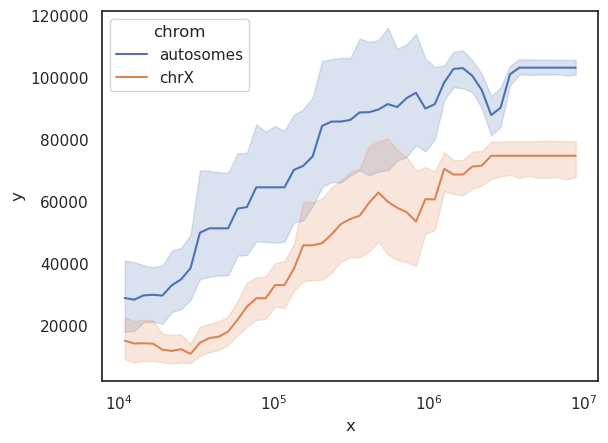

In [24]:
aut_list = glob("../smcpp_pyrho/plots/autosome*.csv")
df_list = []
for aut in aut_list:
    aut_csv = pd.read_csv(aut)
    df_list.append(aut_csv)
aut_dfs = pd.concat(df_list)
chrX_list = glob("../smcpp_pyrho/plots/chrX*.csv")
df_list = []
for X in chrX_list:
    X_csv = pd.read_csv(X)
    df_list.append(X_csv)
x_dfs = pd.concat(df_list)

x_dfs["chrom"] = "chrX"
aut_dfs["chrom"] = "autosomes"
tf_df = aut_dfs.copy()
#tf_df["y"] = tf_df.y*0.75
#tf_df["chrom"] = "Three_Fourths_Aut"
concat_dfs = pd.concat([aut_dfs, x_dfs])
subset_csv = concat_dfs.loc[(concat_dfs.x > 10000) & (concat_dfs.x < 10000000)]
sns.lineplot(data=subset_csv, x="x", y="y", hue="chrom")
plt.xscale('log')

In [25]:
subset_csv["Origin"] = subset_csv.label.map(dict(zip([x.replace(" ", "_").split(",")[0] for x in result_order], result_order)))

/tmp/62431804/ipykernel_92408/754088835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_csv["Origin"] = subset_csv.label.map(dict(zip([x.replace(" ", "_").split(",")[0] for x in result_order], result_order)))


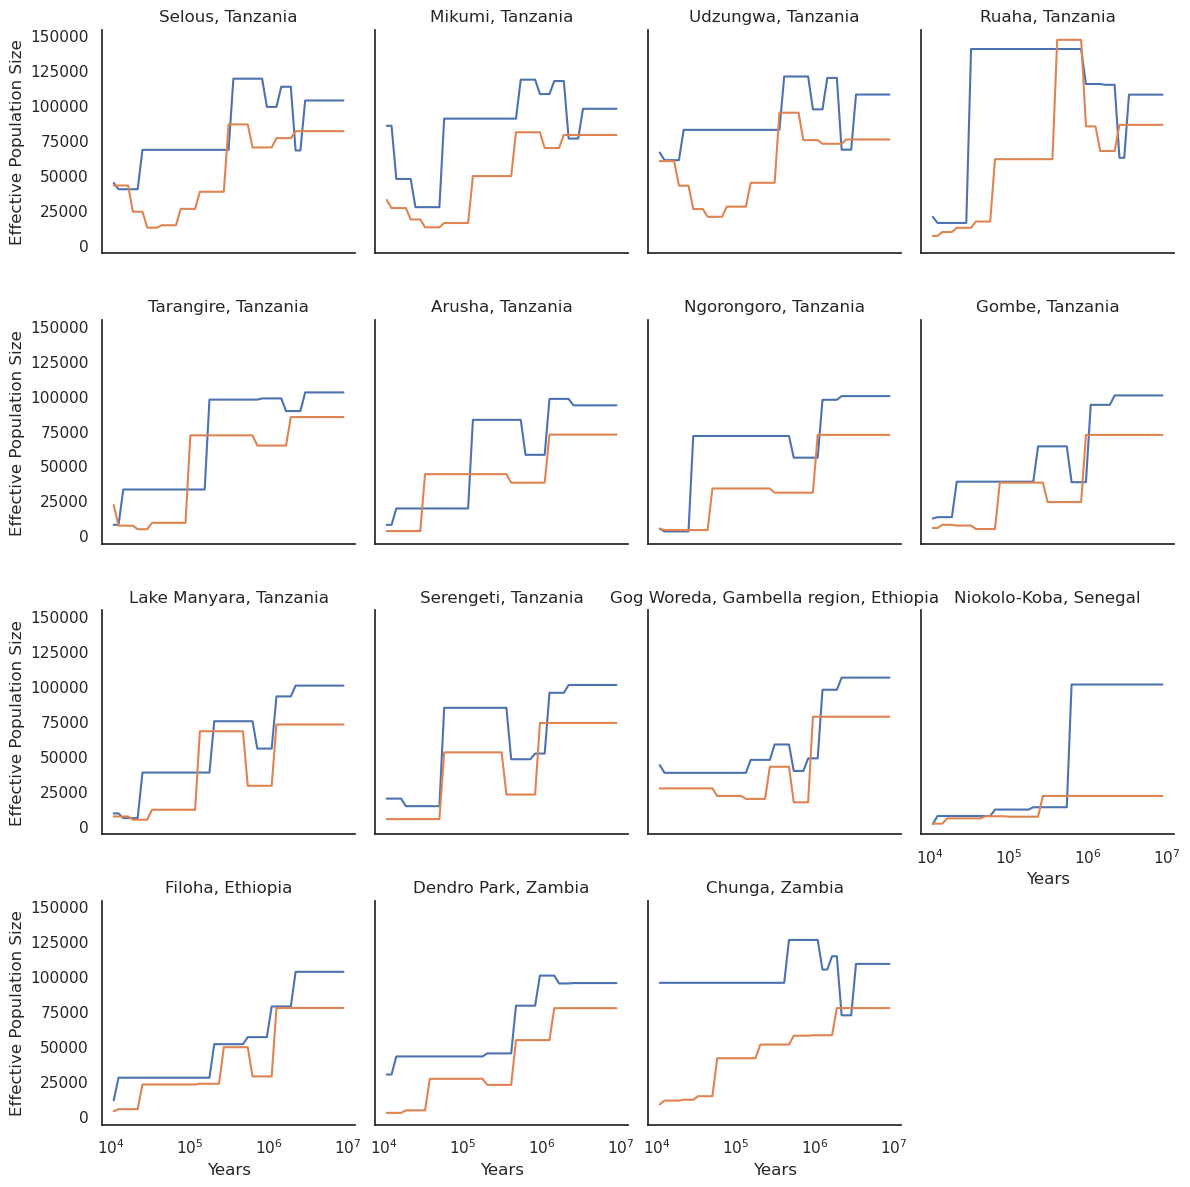

In [26]:
g = sns.FacetGrid(subset_csv, col="Origin",
                  col_wrap = 4, col_order=result_order)
g.map_dataframe(sns.lineplot,data=subset_csv, x="x", y="y", hue="chrom")
g.set_titles(col_template="{col_name}")
g.set_xlabels("Years")
g.set_ylabels("Effective Population Size")

plt.xscale('log')
#plt.yscale('log')

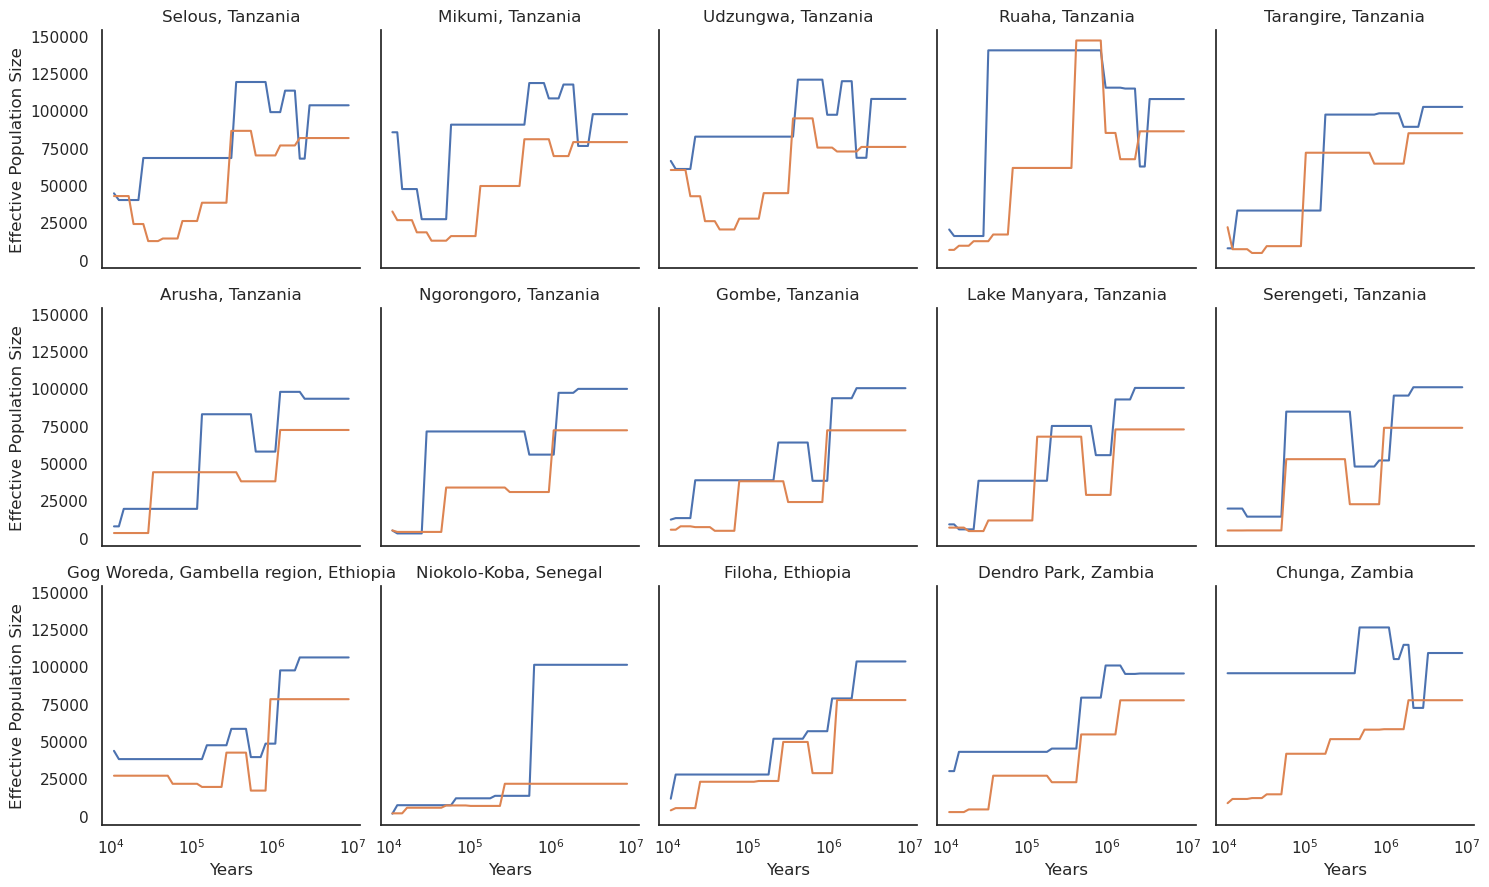

In [27]:
g = sns.FacetGrid(subset_csv, col="Origin",
                  col_wrap = 5, col_order=result_order)
g.map_dataframe(sns.lineplot,data=subset_csv, x="x", y="y", hue="chrom")
g.set_titles(col_template="{col_name}")
g.set_xlabels("Years")
g.set_ylabels("Effective Population Size")

plt.xscale('log')

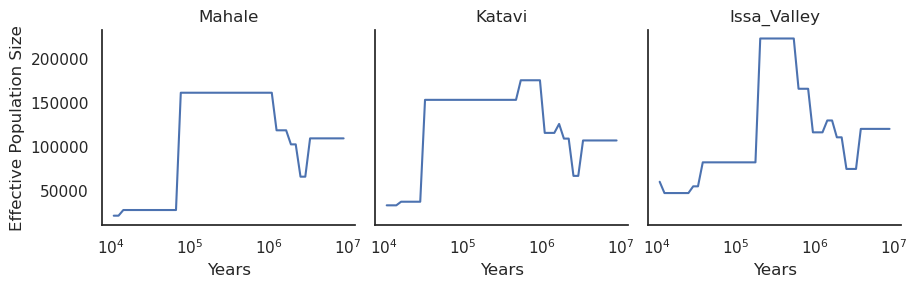

In [29]:
g = sns.FacetGrid(subset_csv.loc[subset_csv.chrom == "autosomes"], col="label",
                  col_wrap = 4, col_order=["Mahale", "Katavi", "Issa_Valley"])
g.map_dataframe(sns.lineplot,data=subset_csv, x="x", y="y")
g.set_titles(col_template="{col_name}")
g.set_xlabels("Years")
g.set_ylabels("Effective Population Size")

plt.xscale('log')

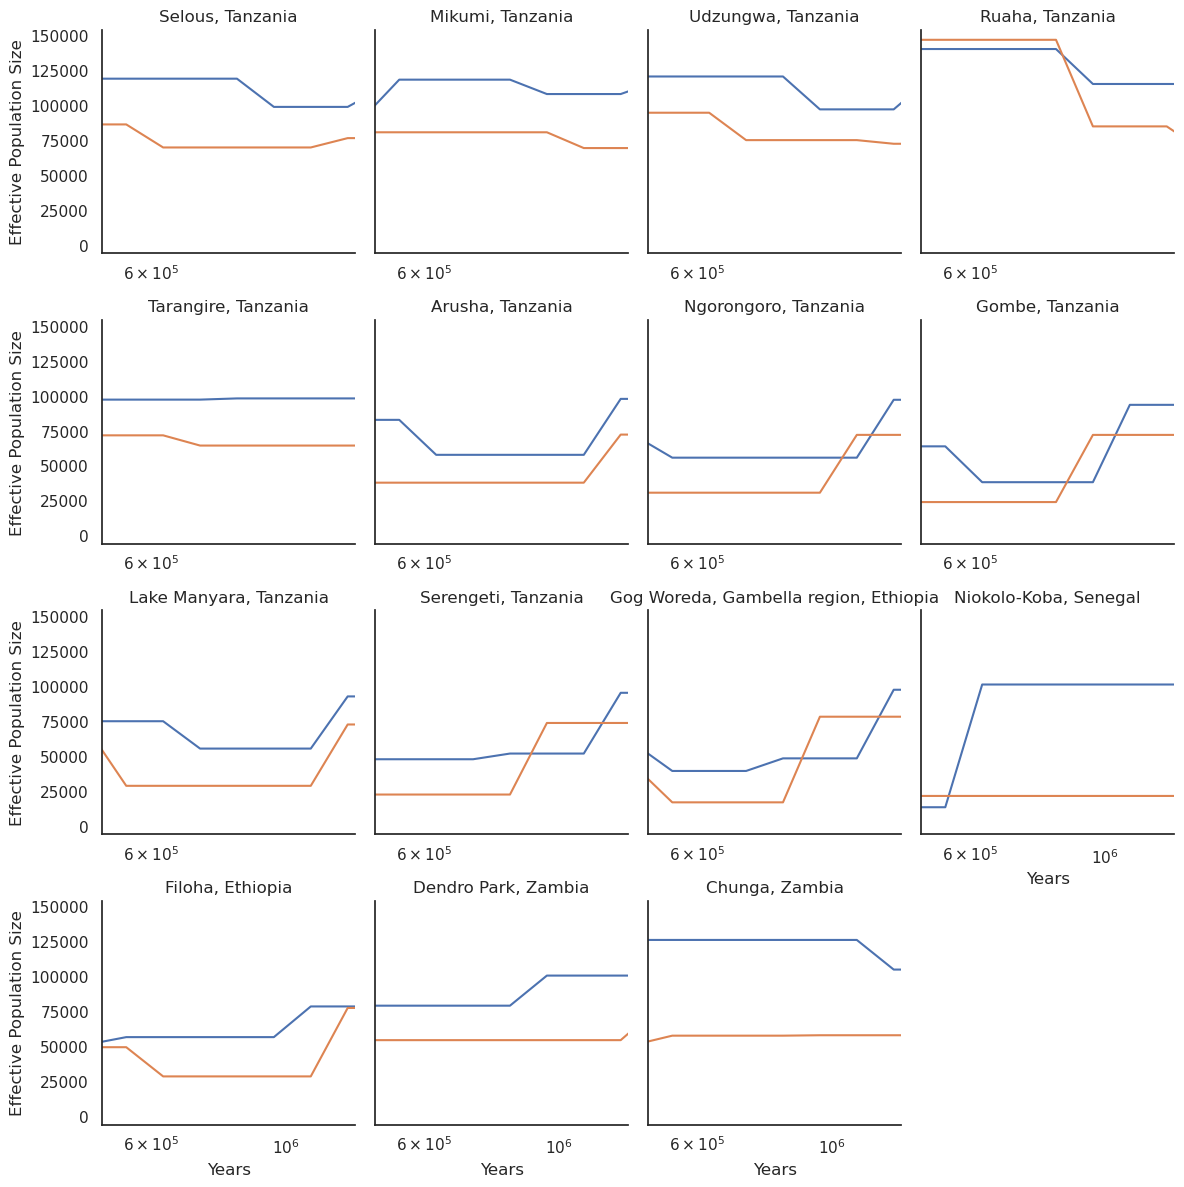

In [27]:
g = sns.FacetGrid(subset_csv, col="Origin",
                  col_wrap = 4, col_order=result_order)
g.map_dataframe(sns.lineplot,data=subset_csv, x="x", y="y", hue="chrom")
g.set_titles(col_template="{col_name}")
g.set_xlabels("Years")
g.set_ylabels("Effective Population Size")
g.set(xlim=(500000, 1300000))
plt.xscale('log')

#plt.yscale('log')

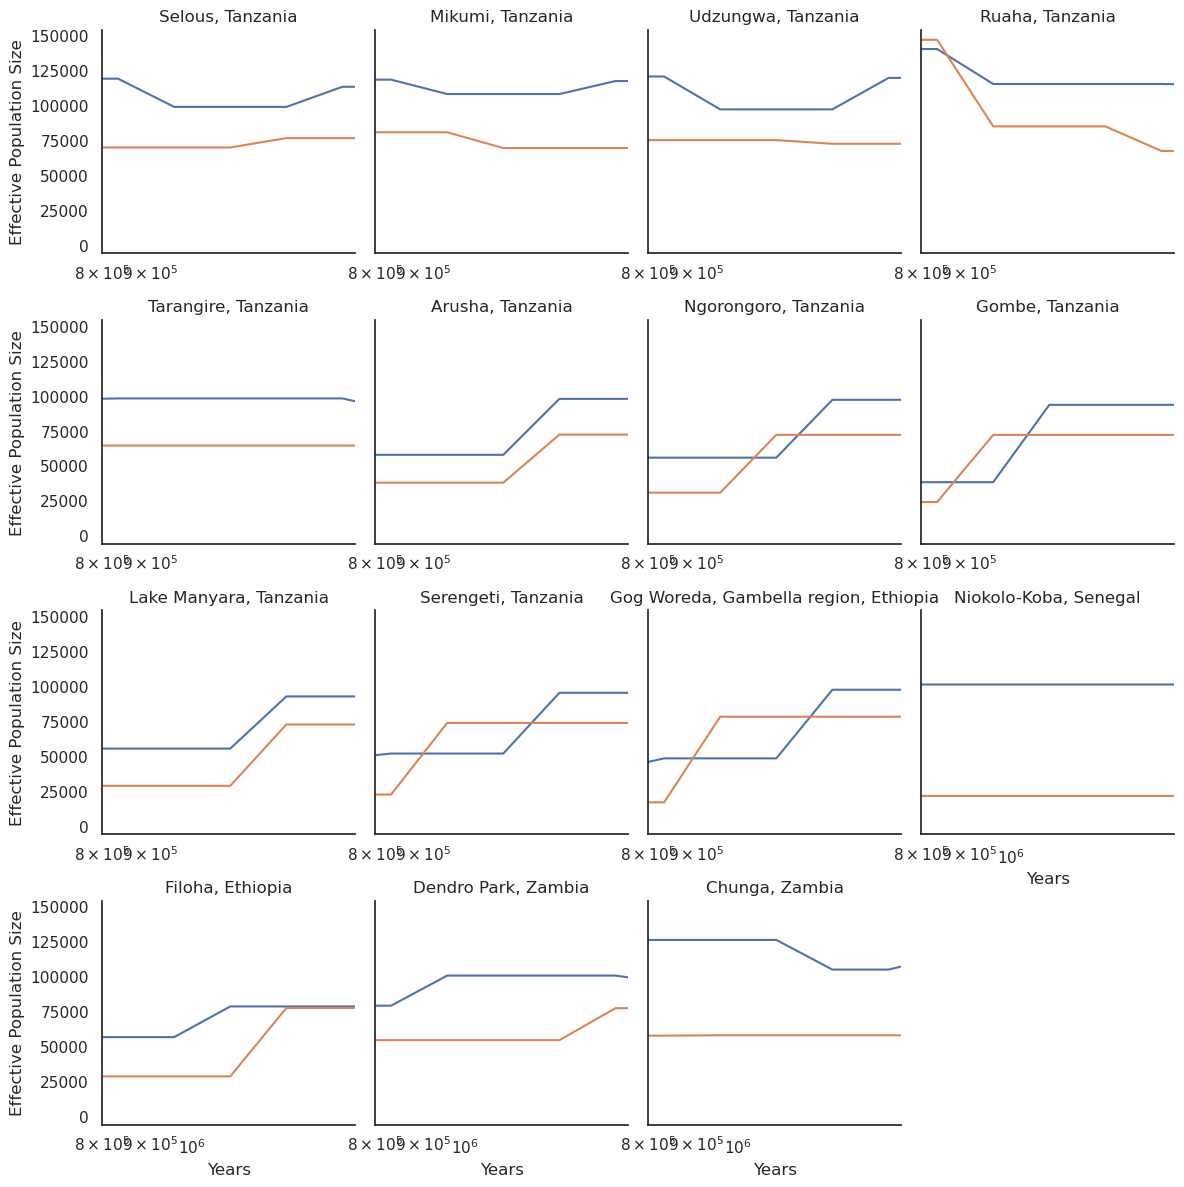

In [50]:
g = sns.FacetGrid(subset_csv, col="Origin",
                  col_wrap = 4, col_order=result_order)
g.map_dataframe(sns.lineplot,data=subset_csv, x="x", y="y", hue="chrom")
g.set_titles(col_template="{col_name}")
g.set_xlabels("Years")
g.set_ylabels("Effective Population Size")
g.set(xlim=(800000, 1500000))
plt.xscale('log')

#plt.yscale('log')

Fst for chrX and the autosomes.

In [21]:
window_size = 100000
all_chroms = ["chr{}".format(x) for x in (range(1, 21))]+["chrX"]

def fst(ac1, ac2):
    num, den = allel.hudson_fst(ac1, ac2, fill=0)
    return np.sum(num) / np.sum(den)

c_df_l2 = []
for c in all_chroms: #["chr4", "chr8", "chrX"]:
    print(c)
    zarr_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/" + c
    #Opening the zarr data
    callset = zarr.open_group(zarr_dir, mode="r")
    gt = allel.GenotypeArray(callset["calldata/GT"])
    pos = callset["variants/POS"][:]
    # Loading in the IDs and gt
    if c == "all_chrX":
        metadata = hap_meta_data_samples
    elif c == "chrX":
        metadata = meta_data_samples_f
    elif c == "dipmale_chrX":
        metadata = meta_data_samples_dip
    else:
        metadata = meta_data_samples
    if c == "chrX":
        rf_c = "female_chrX"
    elif c == "dipmale_chrX":
        rf_c = "all_chrX"
    else:
        rf_c = c
    for i in range(len(result_order)):
        f_1_pop = metadata.loc[metadata.Origin == result_order[i]].callset_index
        f_1_gt = gt.take(f_1_pop, axis=1)
        for j in range(i):
            #print(result_order[i], result_order[j])
            f_2_pop = metadata.loc[metadata.Origin == result_order[j]].callset_index
            f_2_gt = gt.take(f_2_pop, axis=1)
            fst_result, windows, counts = allel.windowed_statistic(pos, (f_1_gt.count_alleles(),
                                                      f_2_gt.count_alleles()), fst, size=window_size, start=0)
            #print(fst_result.mean())
            df = pd.DataFrame({"Fst": fst_result, "start": windows[:,0]})
            df["Origin_1"] = result_order[i]
            df["Origin_2"] = result_order[j]
            df["chrom"] = c
            c_df_l2.append(df)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chrX


In [22]:
fst_df = pd.concat(c_df_l2)
fst_df["chrom_type"] = ["autosome" if x != "chrX" else "chrX" for x in fst_df.chrom]
fst_df = fst_df.merge(c_r_g_df, on=["chrom", "start"])
fst_df = fst_df.loc[fst_df.callable_frac > 0.75]

In [23]:
fst_heatmap = np.array(np.zeros((len(result_order), len(result_order))))
qval_heatmap = np.array(np.zeros((len(result_order), len(result_order))))
p_list = []
for i in range(len(result_order)):
    for j in range(i):
        print(result_order[i], result_order[j])
        d = fst_df.loc[(fst_df.Origin_1 == result_order[i]) &
                      (fst_df.Origin_2 == result_order[j])]
        U1, pnorm = mannwhitneyu(d.loc[d.chrom != "chrX"].Fst,
                                d.loc[d.chrom == "chrX"].Fst)
        print(pnorm, d.loc[d.chrom != "chrX"].Fst.mean(), d.loc[d.chrom == "chrX"].Fst.mean())
        mean_pn = div_results.loc[div_results.Origin.isin([result_order[j], result_order[i]])]["Pool-Nielsen Ratio"].mean()
        U1, pnorm = mannwhitneyu(d.loc[d.chrom != "chrX"].Fst*mean_pn,
                                d.loc[d.chrom == "chrX"].Fst)
        print(pnorm)
        p_list.append(pnorm)
        print(np.log(1-d.loc[d.chrom != "chrX"].Fst.mean())/np.log(1-d.loc[d.chrom == "chrX"].Fst.mean()))
        fst_heatmap[i][j] = d.loc[d.chrom != "chrX"].Fst.mean()
        fst_heatmap[j][i] = d.loc[d.chrom == "chrX"].Fst.mean()
        qval_heatmap[i][j] = mean_pn
        qval_heatmap[j][i] = np.log(1-d.loc[d.chrom != "chrX"].Fst.mean())/np.log(1-d.loc[d.chrom == "chrX"].Fst.mean())

Mikumi, Tanzania Selous, Tanzania
9.240287257401603e-06 0.02787233378379383 0.045915417026508865
0.0010030198220427155
0.6014120233489199
Udzungwa, Tanzania Selous, Tanzania
3.430553696071066e-21 0.02950898685623628 0.022913935431967798
2.122821619610757e-17
1.292167319156864
Udzungwa, Tanzania Mikumi, Tanzania
0.1424631540492106 0.03484581261719852 0.0467129210298004
5.408152756881594e-10
0.7413882947817731
Ruaha, Tanzania Selous, Tanzania
1.2690057524040564e-32 0.06693122117440653 0.1483284889357477
1.6609825030168858e-54
0.4314822446252521
Ruaha, Tanzania Mikumi, Tanzania
1.3687724135104345e-224 0.06811141430419984 0.15508511647595644
0.0
0.41859881082258116
Ruaha, Tanzania Udzungwa, Tanzania
2.955041993123607e-19 0.06532468683080872 0.10182257226567677
5.0602908094966244e-54
0.629086018244843
Tarangire, Tanzania Selous, Tanzania
2.4411868720214e-70 0.3108615458694727 0.4161250136139342
2.5607020258145404e-242
0.6919437941316162
Tarangire, Tanzania Mikumi, Tanzania
3.283986719954918

1.2430817598962983e-109 0.5118572968704225 0.5968440420172958
0.0
0.7894345969796148
Niokolo-Koba, Senegal Gog Woreda, Gambella region, Ethiopia
7.404138306145444e-118 0.5307750993115573 0.6176378736700197
0.0
0.7870638766439917
Filoha, Ethiopia Selous, Tanzania
1.4387041081726066e-172 0.42469462388881213 0.566987659338885
0.0
0.660527505830559
Filoha, Ethiopia Mikumi, Tanzania
0.0 0.43039385665570656 0.5900384280398542
0.0
0.6311711082660629
Filoha, Ethiopia Udzungwa, Tanzania
1.6296538316854155e-159 0.42010598309474345 0.5293995712632193
0.0
0.7229358430361528
Filoha, Ethiopia Ruaha, Tanzania
1.3754351302030258e-189 0.3760364630234072 0.4927251773247222
0.0
0.6949487293619101
Filoha, Ethiopia Tarangire, Tanzania
4.177917972750413e-41 0.3452561008486159 0.4036075794184816
0.0
0.8193980175991903
Filoha, Ethiopia Arusha, Tanzania
8.467774832469654e-39 0.37292845652590995 0.45065413361520373
3.443885222517063e-306
0.7790877663029705
Filoha, Ethiopia Ngorongoro, Tanzania
1.133362707644408

In [25]:
len(fst_df.loc[fst_df.Fst == 1])/len(fst_df), len(fst_df.loc[fst_df.Fst <= 0])/len(fst_df)

(1.0574569218486463e-06, 0.021014841407898145)

In [26]:
np.log(1-d.loc[d.chrom != "chrX"].Fst.mean())/np.log(1-d.loc[d.chrom == "chrX"].Fst.mean())

0.4045806032967905

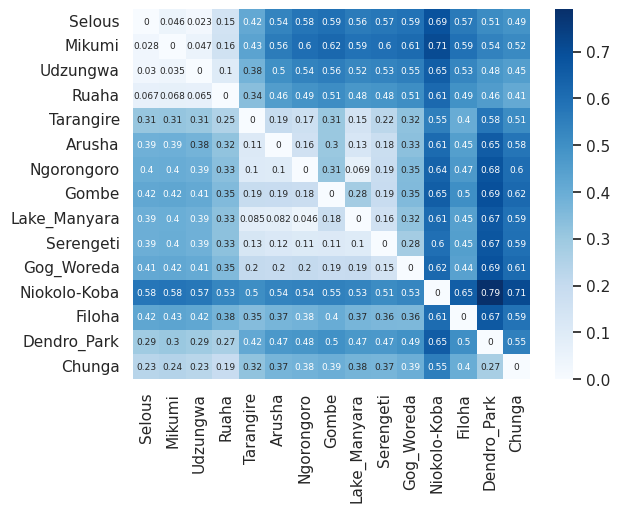

In [27]:
heatmap_df = pd.DataFrame(np.nan_to_num(fst_heatmap), index = [x.replace(" ", "_").split(",")[0] for x in result_order],
                         columns = [x.replace(" ", "_").split(",")[0] for x in result_order])
g = sns.heatmap(heatmap_df, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, annot_kws={"fontsize":6.5})


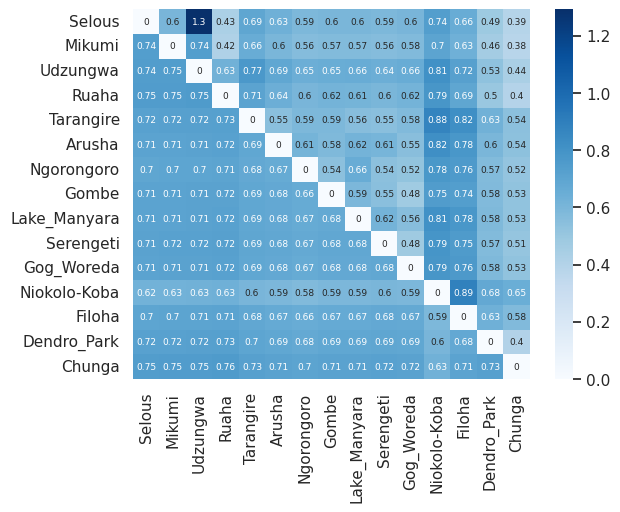

In [28]:
heatmap_pval_df = pd.DataFrame(np.nan_to_num(qval_heatmap), index = [x.replace(" ", "_").split(",")[0] for x in result_order],
                         columns = [x.replace(" ", "_").split(",")[0] for x in result_order])
g = sns.heatmap(heatmap_pval_df, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, annot_kws={"fontsize":6.5})


In [29]:
qval_ratio_heatmap = np.array(np.zeros((len(result_order), len(result_order))))
for i in range(len(result_order)):
    for j in range(i):
        qval_ratio_heatmap[i][j] = qval_heatmap[j][i]/qval_heatmap[i][j]

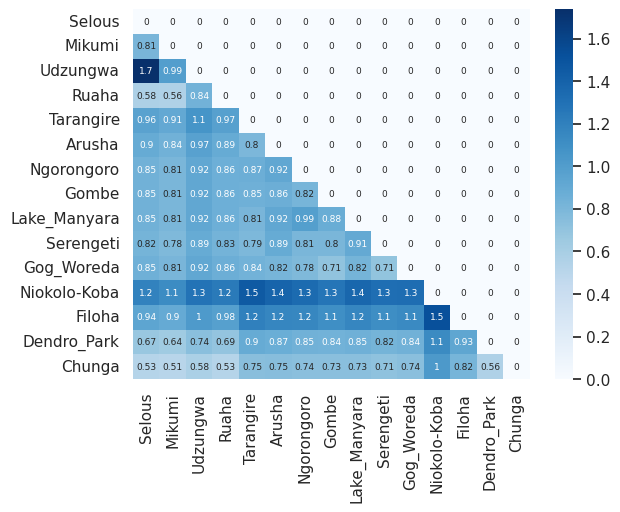

In [30]:
ratio_df = pd.DataFrame(np.nan_to_num(qval_ratio_heatmap), index = [x.replace(" ", "_").split(",")[0] for x in result_order],
                         columns = [x.replace(" ", "_").split(",")[0] for x in result_order])
g = sns.heatmap(ratio_df, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, annot_kws={"fontsize":6.5})
